In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/PDFs")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/DetResponse")
sys.path.append("/data/user/tchau/Sandbox/GC_OscNext/Utils")

from Detector import *
from Signal import *
from Plot_Histogram import *
from Utils import *

In [2]:
MC = ExtractMC(['121122', '141122', '161122'])

In [99]:
len(MC["E_reco"])

5245061

In [98]:
Bin = Std_Binning(1000, N_Etrue=300)

In [91]:
np.min(MC["E_true"])

1.0000271793391269

In [111]:
def EffArea_MC(MCcut, Bin, weight_cut=True):
    Eff=dict()
    
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}

    for nu_type in nu_types:
        loc = np.where(  (MCcut["nutype"]==pdg_encoding[nu_type])
                        # & (MCcut["w"] <= 5000.)

                        & (MCcut["E_reco"] >= np.min(Bin["reco_energy_edges"]))
                        & (MCcut["E_reco"] <= np.max(Bin["reco_energy_edges"]))

                        # & (MCcut["E_true"] < 3100)
                        # & (MCcut["E_true"] > np.min(Bin["true_energy_center"]))
                        # & (MCcut["psi_true"] < np.max(Bin["true_psi_center"]))
                        # & (MCcut["psi_true"] > np.min(Bin["true_psi_center"]))
                        # & (psireco < np.max(Bin["reco_psi_center"]))
                        # & (psireco > np.min(Bin["reco_psi_center"]))
                        )

        #Extract MC events: 
        #NOTE: input psi in deg!
        psitrue = MCcut["psi_true"][loc]
        Etrue = MCcut["E_true"][loc]
        # psireco = psireco[loc]
        # Ereco = MCcut["E_reco"][loc]
        w = MCcut["w"][loc]


        if weight_cut:
            w_lim = define_weightcut(w, 200) #Previously 200
            print ("##Applying cut on weight##")
            print ("Weight lim:", w_lim)
            w_loc = np.where(w<=w_lim)
            #Renormalise weight for total weight to be unchanged
            w = w[w_loc] * (np.sum(w)/np.sum(w[w_loc]))
            psitrue = psitrue[w_loc]
            Etrue = Etrue[w_loc]




        Eff[nu_type], edges =np.histogramdd((psitrue, Etrue),
                                bins = (Bin['true_psi_edges'], Bin['true_energy_edges']),
                                weights=w)
    return Eff

In [112]:
Eff_MC = EffArea_MC(MC, Bin)

##Applying cut on weight##
Weight lim: 12684.998303828395
##Applying cut on weight##
Weight lim: 6314.301984560494
##Applying cut on weight##
Weight lim: 10107.161198118602
##Applying cut on weight##
Weight lim: 20943.058362938544
##Applying cut on weight##
Weight lim: 9599.365168470102
##Applying cut on weight##
Weight lim: 14113.65870159228


/tmp/ipykernel_26425/2852331593.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(Eff_MC['nu_e'], np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), r"$\psi_{true}$", r"$E_{true}$", "Effective Area", zlogscale=True)


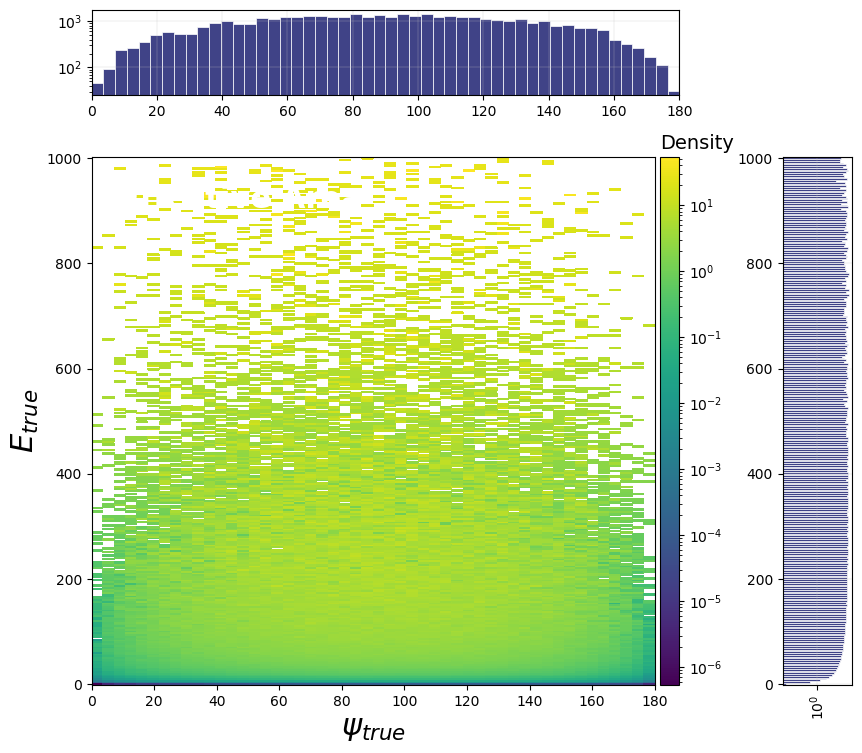

In [113]:
plot_projections(Eff_MC['nu_e'], np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), r"$\psi_{true}$", r"$E_{true}$", "Effective Area", zlogscale=True)


In [114]:
Reco = RecoRate('WW', 3000, 'NFW', Bin, set='1122')
Resp_KDE = Reco.ComputeResp()

********************
Computing Response Matrix
********************
Accessing MC set 1122


In [115]:
np.sum(Resp_KDE['nu_e'])

42677.249408637654

/tmp/ipykernel_26425/2047967023.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_projections(Resp_KDE['nu_e'].sum(axis=(2,3)), np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), r"$\psi_{true}$", r"$E_{true}$", "Effective Area", zlogscale=True)


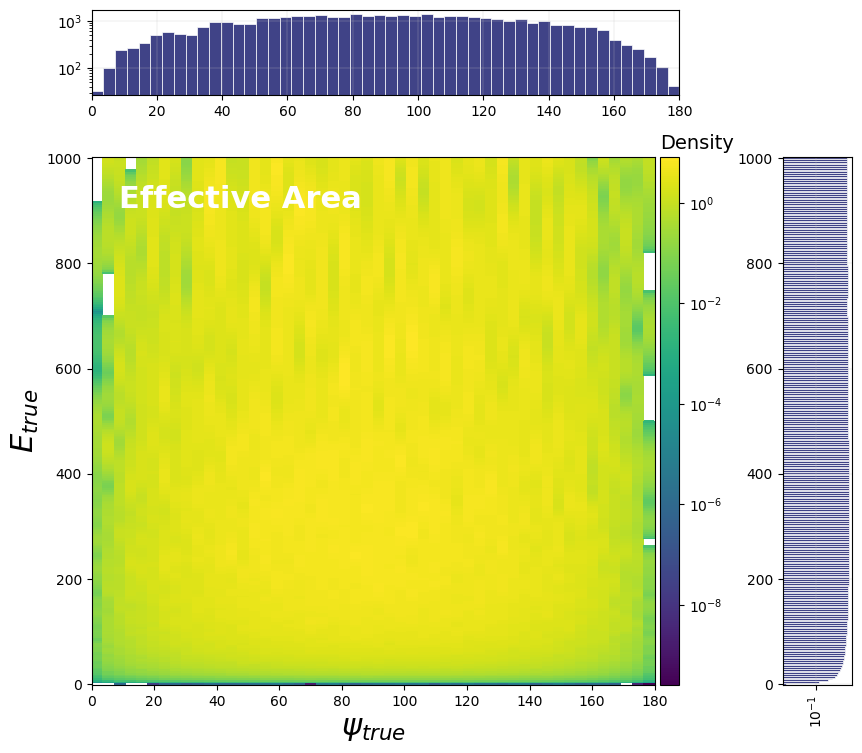

In [116]:
plot_projections(Resp_KDE['nu_e'].sum(axis=(2,3)), np.array([Bin['true_psi_edges'], Bin['true_energy_edges']]), r"$\psi_{true}$", r"$E_{true}$", "Effective Area", zlogscale=True)

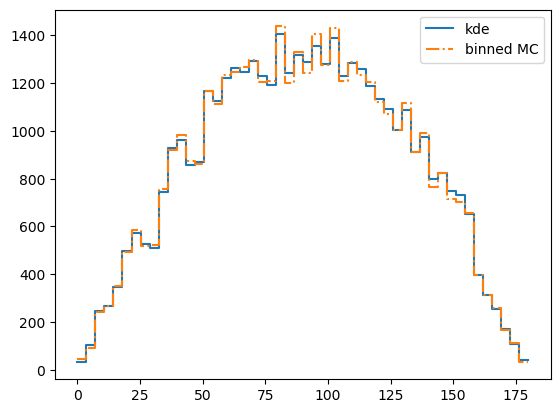

In [120]:
nu = 'nu_e'
Eff_kde_psi = hist_line(Resp_KDE[nu].sum(axis=(1,2,3)), Bin['true_psi_edges'])
Eff_MC_psi = hist_line(Eff_MC[nu].sum(axis=1), Bin['true_psi_edges'])
plt.plot(Eff_kde_psi[0], Eff_kde_psi[1], label='kde')
plt.plot(Eff_MC_psi[0], Eff_MC_psi[1], label='binned MC',ls='-.')

# plt.semilogy()
plt.legend()

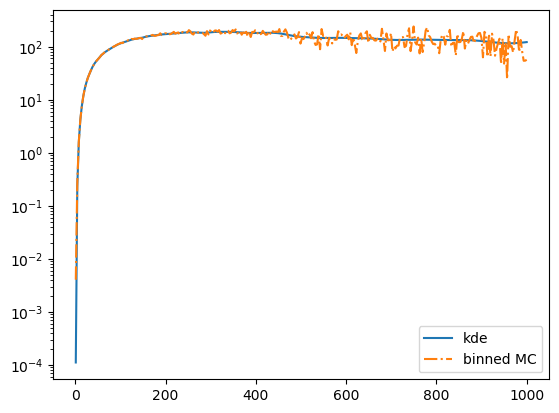

In [140]:
nu = 'nu_e'
Eff_kde_E = Resp_KDE['nu_e'].sum(axis=(0,2,3))
Eff_MC_E = Eff_MC['nu_e'].sum(axis=0)
plt.plot(Bin['true_energy_center'], Eff_kde_E, label='kde')
plt.plot(Bin['true_energy_center'], Eff_MC_E, label='binned MC', ls='-.')



plt.semilogy()
plt.semilogx()
plt.legend()

In [122]:
def Resolution(Resp):
    Reso=dict()
    
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    for nu_type in nu_types:
        Eff = Resp[nu_type].sum(axis=(2,3))
        Eff = np.repeat(Eff[:, :, np.newaxis], Resp[nu_type].shape[2], axis=(2))
        Eff = np.repeat(Eff[:, :, :, np.newaxis], Resp[nu_type].shape[3], axis=(3))
        Reso[nu_type] = Resp[nu_type]/Eff

    return Reso
        

In [123]:
Reso = Resolution(Resp_KDE)

In [124]:
def PsiReso(Reso, Bin, quantile):
    PsiRes=dict()
    
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    for nu_type in nu_types:
        PsiRes[nu_type] = np.zeros((len(Bin['true_psi_center']), len(quantile)))
        res_psi = Reso[nu_type].sum(axis=(1,3))
        for i in range(len(Bin['true_psi_center'])):
           PsiRes[nu_type][i] = weighted_quantile(Bin['reco_psi_center'], quantile, sample_weight=res_psi[i,:], values_sorted=True, old_style=True)
    return PsiRes       

In [125]:
def EReso(Reso, Bin, quantile):
    ERes=dict()
    
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    for nu_type in nu_types:
        ERes[nu_type] = np.zeros((len(Bin['true_energy_center']), len(quantile)))
        res_E = Reso[nu_type].sum(axis=(0,2))
        for i in range(len(Bin['true_energy_center'])):
           ERes[nu_type][i] = weighted_quantile(Bin['reco_energy_center'], quantile, sample_weight=res_E[i,:], values_sorted=True, old_style=True)
    return ERes   

In [132]:
PsiRes = PsiReso(Reso, Bin, [0.1,0.5,0.9])

##Applying cut on weight##
Weight lim: 90.86370891089597
##Applying cut on weight##
Weight lim: 48.5737360282462
##Applying cut on weight##
Weight lim: 746.1575310655473
##Applying cut on weight##
Weight lim: 564.9059705146814
##Applying cut on weight##
Weight lim: 174.75408550110865
##Applying cut on weight##
Weight lim: 692.0596796384154
##Applying cut on weight##
Weight lim: 923.1285360893195
##Applying cut on weight##
Weight lim: 2281.414527889506
##Applying cut on weight##
Weight lim: 629.9441788046798
##Applying cut on weight##
Weight lim: 1301.3659342373016
##Applying cut on weight##
Weight lim: 1630.222541715442
##Applying cut on weight##
Weight lim: 650.2414661072705
##Applying cut on weight##
Weight lim: 692.6149394916079
##Applying cut on weight##
Weight lim: 2089.8209064623416
##Applying cut on weight##
Weight lim: 1661.5108669605115
##Applying cut on weight##
Weight lim: 1662.9813234742958
##Applying cut on weight##
Weight lim: 1021.143531607866
##Applying cut on weight##


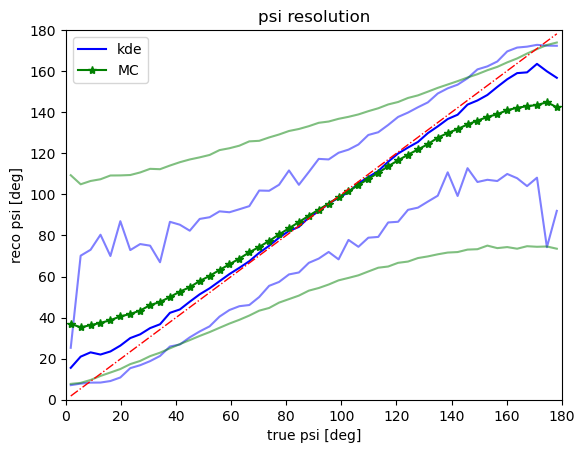

In [138]:
median = [PsiRes['nu_mu'][i][1] for i in range(len(Bin['true_psi_center']))]
low = [PsiRes['nu_mu'][i][0] for i in range(len(Bin['true_psi_center']))]
up = [PsiRes['nu_mu'][i][2] for i in range(len(Bin['true_psi_center']))]

plt.plot(Bin['true_psi_center'], median, color='blue', label='kde')
plt.plot(Bin['true_psi_center'], low, color='blue', alpha=0.5)
plt.plot(Bin['true_psi_center'], up, color='blue', alpha=0.5)
plt.ylim(0,180)


# MC
psitrue = Bin['true_psi_edges']
# psitrue = np.linspace(0,180, 500)

psi = np.array([])
median = np.array([])
low = np.array([])
up = np.array([])
for i in range(psitrue.size-1):
    loc = np.where((MC['psi_true']>= psitrue[i])&
                    (MC['psi_true']<= psitrue[i+1])& (MC['psi_true']<= psitrue[i+1]) & (MC['nutype']==14)
                    & (MC["E_reco"] >= np.min(Bin["reco_energy_edges"]))
                    & (MC["E_reco"] <= np.max(Bin["reco_energy_edges"]))
                    # &( abs(MC['E_reco']-MC['E_true'])<=0.1*MC['E_true'])
                    # &(MC['w']<500)
                    )
    if loc[0].size==0:
        continue
    w_lim = define_weightcut(MC['w'][loc], 200) #Previously 200
    print ("##Applying cut on weight##")
    print ("Weight lim:", w_lim)
    w_loc = np.where(MC['w'][loc]<=w_lim)

    psi = np.append(psi, (psitrue[i]+psitrue[i+1])/2.)

    psireco = MC['psi_reco'][loc][w_loc]
    reso = np.quantile(psireco, [0.1, 0.5, 0.9])
    low = np.append(low, reso[0])
    median = np.append(median, reso[1])
    up = np.append(up, reso[2])

plt.plot(psi, median, marker='*', color='green', label='MC')
plt.plot(psi, low, color='green', alpha=0.5)
plt.plot(psi, up, color='green', alpha=0.5)
plt.plot(psi, psi, color='red', ls='-.', lw=1)
plt.title('psi resolution')
plt.xlabel('true psi [deg]')
plt.ylabel('reco psi [deg]')
# plt.semilogx()
# plt.semilogy()   
plt.ylim(0,180)
plt.xlim(0,180)
plt.legend()

/tmp/ipykernel_26425/1144491919.py:49: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1000)


(0.7079457843841379, 1000)

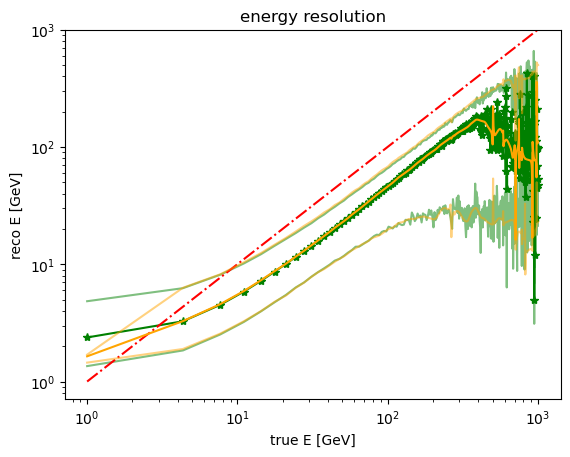

In [141]:

# MC
Etrue = Bin['true_energy_edges']
# psitrue = np.linspace(0,180, 500)

E = np.array([])
median = np.array([])
low = np.array([])
up = np.array([])
for i in range(Etrue.size-1):
    loc = np.where((MC['E_true']>= Etrue[i])&
                    (MC['E_true']<= Etrue[i+1])& (MC['E_true']<= Etrue[i+1]) & (MC['nutype']==12)
                    # &( abs(MC['E_reco']-MC['E_true'])<=0.1*MC['E_true'])
                    # &(MC['w']<50)
                    )
    if loc[0].size==0:
        continue
    E = np.append(E, (Etrue[i]+Etrue[i+1])/2.)

    Ereco = MC['E_reco'][loc]
    reso = np.quantile(Ereco, [0.1, 0.5, 0.9])
    low = np.append(low, reso[0])
    median = np.append(median, reso[1])
    up = np.append(up, reso[2])

plt.plot(E, median, marker='*', color='green', label='MC')
plt.plot(E, low, color='green', alpha=0.5)
plt.plot(E, up, color='green', alpha=0.5)
plt.plot(E, E, color='red', ls='-.')


# kde
ERes = EReso(Reso, Bin, [0.1,0.5,0.9])

median = [ERes['nu_e'][i][1] for i in range(len(Bin['true_energy_center']))]
low = [ERes['nu_e'][i][0] for i in range(len(Bin['true_energy_center']))]
up = [ERes['nu_e'][i][2] for i in range(len(Bin['true_energy_center']))]

plt.plot(Bin['true_energy_center'], median, color='orange', label='kde')
plt.plot(Bin['true_energy_center'], low, color='orange', alpha=0.5)
plt.plot(Bin['true_energy_center'], up, color='orange', alpha=0.5)



plt.title('energy resolution')
plt.xlabel('true E [GeV]')
plt.ylabel('reco E [GeV]')
plt.semilogx()
plt.semilogy()   
plt.ylim(0,1000)
# plt.xlim(0,180)